## Importing libraries

In [1]:
from spacy.lang.en import English
import csv as csv
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split as split
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

## Reading and splitting

In [2]:
nlp = English()
all_labels = []
all_tweets = []

In [3]:
with open("offenseval-training-v1.tsv", encoding='utf8') as mf:
    reader = csv.reader(mf, delimiter="\t")
    for id,tweet,a,b,c in tqdm(reader,'Reading data'):
        if id == "id":
            continue
        all_tweets.append(tweet.lower())
        if a == "OFF":
            all_labels.append(1)
        else:
            all_labels.append(0)

Reading data: 13241it [00:00, 308525.66it/s]


In [4]:
print(all_tweets[0])
#print(all_labels[3])

@user she should ask a few native americans what their take on this is.


In [5]:
tr_tweets,tst_tweets,tr_labels,tst_labels = split(all_tweets,all_labels,test_size=0.3)

### Preprocessing

In [6]:
prep_tr_tweets = []
prep_tst_tweets = []
tr_vecs = []
tst_vecs = []
other_stopwords = ['.',',',':','#','-','"','!','?','*','&','@','˝',')','(',';','´',' ','/','@user']

In [7]:
for i, tweet in tqdm(enumerate(tr_tweets), 'Token and Lemmatization', position=0):
    temp = nlp(tweet)
    words = []
    for j, token in enumerate(temp):
        if not token.is_stop and token.text not in other_stopwords:
            words.append((token.lemma_))
    prep_tr_tweets.append(words)
for i, tweet in tqdm(enumerate(tst_tweets), 'Token and Lemmatization', position=0):
    temp = nlp(tweet)
    asd = []
    for j, token in enumerate(temp):
        if not token.is_stop and token.text not in other_stopwords:
            asd.append((token.lemma_))
    prep_tst_tweets.append(asd)

Token and Lemmatization: 9268it [00:01, 7172.21it/s]
Token and Lemmatization: 3972it [00:00, 8651.14it/s]


In [8]:
print(prep_tr_tweets[7])

['fuck', 'yes', 'pressure', 'pit', 'open']


## Vectorizing

In [9]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r', encoding='utf-8')
    model = {}
    for line in tqdm(f, 'Loading', position=0):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [10]:
model = loadGloveModel('glove.twitter.27B.25d.txt')

Loading Glove Model


Loading: 1193514it [00:11, 99558.95it/s] 


Done. 1193514  words loaded!


In [11]:
#from wordsegment import load, segment
#load()

In [12]:
vectors = [np.array([model[word] for word in tweet if word in model]).flatten() for tweet in tqdm(prep_tr_tweets,'Vectorizing')]

max_len = np.max([len(vector) for vector in vectors])
vectors = [
    np.array(vector.tolist()+[0 for _ in range(max_len-len(vector))]) for vector in tqdm(vectors,'Finalizing')
    ]
for i,vec in enumerate(vectors):
    vectors[i] = vec[:max_len]
tr_vecs.append(vectors)

Finalizing: 100%|███████████████████████████████████████████████████████████████| 9268/9268 [00:00<00:00, 12345.60it/s]


In [13]:
vectors = [np.array([model[word] for word in tweet if word in model]).flatten() for tweet in tqdm(prep_tst_tweets,'Vectorizing')]

vectors = [
    np.array(vector.tolist()+[0 for _ in range(max_len-len(vector))]) for vector in tqdm(vectors,'Finalizing')
    ]
for i,vec in enumerate(vectors):
    vectors[i] = vec[:max_len]
tst_vecs.append(vectors)

Finalizing: 100%|███████████████████████████████████████████████████████████████| 3972/3972 [00:00<00:00, 12452.59it/s]


In [14]:
print(len(tr_vecs[0]),len(tst_vecs[0]))

9268 3972


## Classifiers

In [ ]:
classifier = SVC
params = {'C':10,'kernel':'rbf'}
modell = classifier(**params)
modell.fit(tr_vecs[0],tr_labels)

In [15]:
def confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

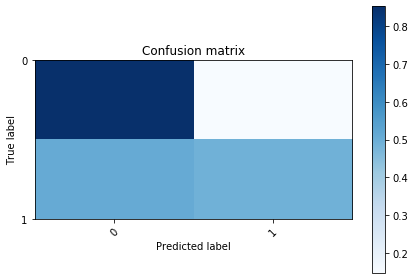

In [16]:
test_data = np.array(tst_vecs[0])
test_labels = np.array(tst_labels).reshape(-1,1)
predicted_tst_labels = modell.predict(test_data)
conf = np.zeros([2,2])
confnorm = np.zeros([2,2])
for i in range(0,test_data.shape[0]):
    j = test_labels[i,:]
    k = predicted_tst_labels[i]
    conf[j,k] = conf[j,k] + 1
for i in range(0,2):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
confusion_matrix(confnorm, labels=[i for i in range(2)])
acc = modell.score(test_data,test_labels)

In [17]:
print(acc)

0.7316213494461229
